In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from util.data_management import concate_data, load_data_raw, display_data, data_to_fft
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn import metrics
from easydict import EasyDict

In [5]:
args = EasyDict({
    'dir_path' : r"D:\Anomaly-Dataset\sar400_vibration_data",
    'is_normal' : True,
    'is_train' : True,
    'stop_idx' : 1
})

train_data_0, train_data_1, train_data_2, train_data_3, validation_data_0, validation_data_1, validation_data_2, validation_data_3 = load_data_raw(
    dir_path=args.dir_path, 
    is_normal=args.is_normal, 
    is_train=args.is_train, 
    stop_idx=args.stop_idx
    )

test_data_0, test_data_1, test_data_2, test_data_3 = load_data_raw(
    dir_path=args.dir_path,
    is_normal=False,
    is_train=False,
    stop_idx=args.stop_idx
)

 10%|█         | 1/10 [00:01<00:13,  1.45s/it]


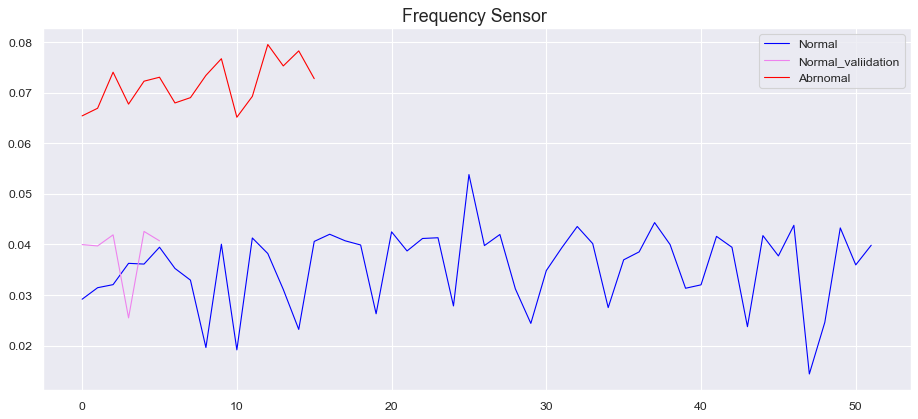

In [9]:
display_data(train_data_0, validation_data_0, test_data_0)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = MinMaxScaler()
X_train_0 = scaler.fit_transform(train_data_0)
X_train_1 = scaler.transform(train_data_1)
X_train_2 = scaler.transform(train_data_2)
X_train_3 = scaler.transform(train_data_3)

X_validation_0 = scaler.transform(validation_data_0)
X_validation_1 = scaler.transform(validation_data_1)
X_validation_2 = scaler.transform(validation_data_2)
X_validation_3 = scaler.transform(validation_data_3)

X_test_0 = scaler.transform(test_data_0)
X_test_1 = scaler.transform(test_data_1)
X_test_2 = scaler.transform(test_data_2)
X_test_3 = scaler.transform(test_data_3)

In [ ]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(64, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(32, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(32, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(64, activation='relu', return_sequences=True)(L4)

    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
X_train = concate_data((X_train_0, X_train_1, X_train_2, X_train_3), axis=1)
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), axis=1)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

In [ ]:
nb_epochs = 100
batch_size = 256

checkpoint_path = "model/checkpoint.pt"

callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)]
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,callbacks=callbacks, validation_split=0.1).history

model.load_weights(checkpoint_path)
model.save("model/model_concate.h5")

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
X_validation = concate_data((X_validation_0, X_validation_1, X_validation_2, X_validation_3), axis=1)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])

X_test = concate_data((X_test_0, X_test_1, X_test_2, X_test_3), axis=1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = tf.keras.models.load_model('model/model_concate.h5')
predictons_3d = model.predict(X_validation)
predictions = predictons_3d.reshape(predictons_3d.shape[0], predictons_3d.shape[2])
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
mse = np.mean(np.power(X_validation - predictions, 2), axis=1)

y_valid = np.ones(len(X_validation))

error_df = pd.DataFrame({'Reconstruction_error':mse,
'True_class': y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]

print(precision_rt[np.argmin(best_cnt_dic)])
print(recall_rt[np.argmin(best_cnt_dic)])
print(threshold_fixed)

plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('model/model_concate.h5')

X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2]) 
X_pred = pd.DataFrame(X_pred)

Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2]) 

scored = pd.DataFrame()
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
# scored['Loss_mae'] = np.mean(X_pred-Xtrain, axis=1) 

Threshold = 0.017

plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
plt.xlim([0,1])
sns.distplot(scored['Loss_mae'], kde= True, color = 'blue')

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./test_log.csv', sep=',')

In [ ]:
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])
X_pred_val = model.predict(X_validation)
X_pred_val = X_pred_val.reshape(X_pred_val.shape[0], X_pred_val.shape[2])
X_pred_val = pd.DataFrame(X_pred_val)

scored_val = pd.DataFrame()
Xvalidation = X_validation.reshape(X_validation.shape[0], X_validation.shape[2])
scored_val['Loss_mae'] = np.mean(np.abs(X_pred_val-Xvalidation), axis=1)
scored_val['Threshold'] = Threshold
scored_val['Anomaly'] = scored_val['Loss_mae'] > scored_val['Threshold']
print(scored_val)
scored_val.to_csv('./validation_log.csv', sep=',')

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

Threshold = 0.3

scored = pd.DataFrame()
Xtest = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred), axis=1)
scored['Threshold'] = Threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored)

scored.to_csv('./train_log.csv', sep=',')